### Table of contents


[- Data processing](#Data-processing)  
[- Neural network training and validating](#Neural-network-training-and-validating)

Neural network training and validating

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, jaccard_score, pairwise_distances
import matplotlib.pyplot as plt
import nbimporter
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import torch
import torch.nn as nn
import torch.optim as optim


from pathlib import Path
current_path = Path().resolve()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [2]:
df_songs = pd.read_csv(current_path / 'Data/Music Info.csv')

df_users = pd.read_csv(current_path / 'Data/User Listening History.csv')

***
### Data processing 
***

- The dataset is seperated into two parts, one including the rows where genre is not available and the other dataset has the rest of the rows.

In [3]:
print("Music info dataset shape: ",df_songs.shape)
print("User listening shape: ",df_users.shape)

Music info dataset shape:  (50683, 21)
User listening shape:  (9711301, 3)


In [4]:
null_count = df_songs.isnull().sum()
null_count = null_count[null_count > 0]
print("Number of null elements in coloumn")
print(null_count)

Number of null elements in coloumn
tags      1127
genre    28335
dtype: int64


In [5]:
# Separate rows where 'genre' is NaN
df_without = df_songs[df_songs['genre'].isna()]

# Separate rows where 'genre' is not NaN. 
df_with = df_songs[df_songs['genre'].notna()]


In [6]:
df_without.shape

(28335, 21)

***
### Neural network training and validating
***

In [ ]:
# Neural Networt

# Select features for one-hot encoding (categorical features)
#categorical_features = ['playlist_name', 'track_artist']
categorical_features = ['artist']

# Apply one-hot encoding
onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
onehot_encoded = onehot_encoder.fit_transform(df_with[categorical_features])

# Convert the one-hot encoded features to a DataFrame
onehot_encoded_df = pd.DataFrame(onehot_encoded, columns=onehot_encoder.get_feature_names_out(categorical_features))

# Merge the one-hot encoded features with the numerical features
numerical_features = df_with[['year','danceability', 'energy', 'tempo', 'acousticness', 'instrumentalness', 
                         'liveness', 'valence', 'loudness', 'speechiness']]

# Combine numerical and one-hot encoded categorical features
#X_combined = pd.concat([numerical_features, onehot_encoded_df], axis=1)
X_combined = pd.concat([numerical_features.reset_index(drop=True), onehot_encoded_df.reset_index(drop=True)], axis=1)

y = df_with['genre']

# Drop the first row just so we can use that song as the input song
X_combined = X_combined.drop(0).reset_index(drop=True)  # Drop the first row from X
y = y.drop(y.index[0]).reset_index(drop=True)  # Drop the first row from y, ensure to use the index

# Encode genres
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_encoded, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

from torch.utils.data import DataLoader, TensorDataset

# Create TensorDataset and DataLoader for training and testing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64  # Set your batch size

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the Neural Network
class Net(nn.Module):
    def __init__(self, num_features, num_hidden, num_output):
        super(Net, self).__init__()
        
        # Input layer to first hidden layer
        self.W_1 = nn.Parameter(torch.empty(num_hidden, num_features))
        nn.init.kaiming_normal_(self.W_1)
        self.b_1 = nn.Parameter(torch.zeros(num_hidden))
        
        # First hidden layer to second hidden layer
        self.W_2 = nn.Parameter(torch.empty(num_hidden, num_hidden))
        nn.init.kaiming_normal_(self.W_2)
        self.b_2 = nn.Parameter(torch.zeros(num_hidden))
        
        # Second hidden layer to output layer
        self.W_3 = nn.Parameter(torch.empty(num_output, num_hidden))
        nn.init.kaiming_normal_(self.W_3)
        self.b_3 = nn.Parameter(torch.zeros(num_output))
        
        # Batch normalization layers
        self.batchnorm1 = nn.BatchNorm1d(num_hidden)
        self.batchnorm2 = nn.BatchNorm1d(num_hidden)
        
        # Activation and dropout
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
    
    def forward(self, x):
        # Input to first hidden layer
        x = torch.mm(x, self.W_1.t()) + self.b_1
        x = self.batchnorm1(x)
        x = self.activation(x)
        x = self.dropout(x)
        
        # First hidden layer to second hidden layer
        x = torch.mm(x, self.W_2.t()) + self.b_2
        x = self.batchnorm2(x)
        x = self.activation(x)
        x = self.dropout(x)
        
        # Second hidden layer to output layer
        x = torch.mm(x, self.W_3.t()) + self.b_3
        return x

# Set model parameters
num_features = X_train_tensor.shape[1]  # Number of input features
num_hidden = 64  # Number of neurons in hidden layers
num_classes = len(set(y_train))  # Number of unique genres (classes)

# Initialize the model
net = Net(num_features, num_hidden, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Multi-class classification loss
optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay=1e-4)

In [ ]:
# Validation function
def validate_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct_test = 0
    total_test = 0
    running_loss = 0.0

    with torch.no_grad():  # No gradient calculation for evaluation
        for inputs, labels in test_loader:
            # Forward pass
            outputs = model(inputs)
            
            # Calculate the loss
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    
    # Calculate average loss and accuracy
    test_loss = running_loss / len(test_loader)
    test_acc = correct_test / total_test
    return test_loss, test_acc

# Training loop with validation
def train_model_with_validation(model, train_loader, test_loader, num_epochs=15):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    model.train()
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        # Calculate training metrics
        epoch_loss = running_loss / len(train_loader)
        train_acc = correct_train / total_train
        
        #Saving the training loss:
        train_losses.append(epoch_loss)
        train_accuracies.append(train_acc)

        # Validate on the test set after each epoch
        test_loss, test_acc = validate_model(model, test_loader)

        #Saving the test loss
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        
        # Print results every 5 epochs
        if (epoch + 1) % 1 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], "
                  f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {train_acc:.4f}, "
                  f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
            
    return train_losses, train_accuracies, test_losses, test_accuracies

# Call the training function with validation
#train_model_with_validation(net, train_loader, test_loader)

train_losses, train_accuracies, test_losses, test_accuracies = train_model_with_validation(net, train_loader, test_loader)



Epoch [1/15], Train Loss: 2.6330, Train Accuracy: 0.2085, Test Loss: 2.0202, Test Accuracy: 0.4814
Epoch [2/15], Train Loss: 1.6070, Train Accuracy: 0.5816, Test Loss: 1.4429, Test Accuracy: 0.6291
Epoch [3/15], Train Loss: 1.0863, Train Accuracy: 0.7252, Test Loss: 1.2389, Test Accuracy: 0.7020
Epoch [4/15], Train Loss: 0.8173, Train Accuracy: 0.8018, Test Loss: 1.1732, Test Accuracy: 0.7268
Epoch [5/15], Train Loss: 0.6707, Train Accuracy: 0.8295, Test Loss: 1.1654, Test Accuracy: 0.7336
Epoch [6/15], Train Loss: 0.5883, Train Accuracy: 0.8400, Test Loss: 1.1772, Test Accuracy: 0.7358
Epoch [7/15], Train Loss: 0.5413, Train Accuracy: 0.8430, Test Loss: 1.1983, Test Accuracy: 0.7360
Epoch [8/15], Train Loss: 0.5082, Train Accuracy: 0.8443, Test Loss: 1.2229, Test Accuracy: 0.7345
Epoch [9/15], Train Loss: 0.4873, Train Accuracy: 0.8437, Test Loss: 1.2438, Test Accuracy: 0.7362
Epoch [10/15], Train Loss: 0.4692, Train Accuracy: 0.8429, Test Loss: 1.2646, Test Accuracy: 0.7383
Epoch [11

In [9]:
# Define the categorical features for the input song (replace with actual values)
input_song_categorical = pd.DataFrame({
    #'playlist_name': ['Pop Remix'],  # Replace with the actual playlist name
    'track_artist': ['Ed Sheeran']      # Replace with the actual track artist
})

# Apply the same one-hot encoding as used in training
input_song_categorical_encoded = onehot_encoder.transform(categorical_features)

# Convert to DataFrame
input_song_categorical_df = pd.DataFrame(input_song_categorical_encoded, columns=onehot_encoder.get_feature_names_out(categorical_features))

# Define the numerical features for the input song (replace with actual values)
input_song_numerical = pd.DataFrame([{
    'danceability': 0.748, 'energy': 0.916, 'tempo': 122.036, 'acousticness': 0.102, 
    'instrumentalness': 0.0, 'liveness': 0.0653, 'valence': 0.518, 'loudness': -2.634, 'speechiness': 0.0583, 
}])

# Combine the one-hot encoded categorical features with the numerical features
input_song_combined = pd.concat([input_song_numerical, input_song_categorical_df], axis=1)

# Ensure the columns match the same order as the training data
input_song_combined = input_song_combined[X_combined.columns]  # Ensure same column order

# Convert to PyTorch tensor
input_song_tensor = torch.tensor(input_song_combined.values, dtype=torch.float32)

# Now use the neural network to predict the genre
net.eval()
with torch.no_grad():
    predicted_genre_tensor = net(X_combined_tensor)
    predicted_genres = torch.argmax(predicted_genre_tensor, dim=1)

# Convert the predicted genre back to its label
predicted_genre_label = label_encoder.inverse_transform([predicted_genre])
print(f"Predicted genre: {predicted_genre_label}")

ValueError: Expected 2D array, got 1D array instead:
array=['artist'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [11]:
# One-hot encode the categorical feature (track_artist) for the entire dataset
onehot_encoded = onehot_encoder.transform(data[['artist']])
onehot_encoded_df = pd.DataFrame(onehot_encoded, columns=onehot_encoder.get_feature_names_out(categorical_features))

# Merge the one-hot encoded features with the numerical features
numerical_features = data[['danceability', 'energy', 'tempo', 'acousticness', 'instrumentalness', 
                         'liveness', 'valence', 'loudness', 'speechiness']]

# Combine numerical and one-hot encoded categorical features
X_combined = pd.concat([numerical_features, onehot_encoded_df], axis=1)

# Scale the data using the previously fitted scaler
X_combined_scaled = scaler.transform(X_combined)

# Convert the scaled data to a PyTorch tensor
X_combined_tensor = torch.tensor(X_combined_scaled, dtype=torch.float32)

net.eval()
with torch.no_grad():  # Disable gradient computation for predictions
    predicted_genre_tensor = net(X_combined_tensor)
    predicted_genres = torch.argmax(predicted_genre_tensor, dim=1)

# Convert the predicted genre indices back to genre labels
predicted_genre_label = label_encoder.inverse_transform(predicted_genres.numpy())

# Add the predicted genres as a new column in the DataFrame
data['predicted_genre'] = predicted_genre_label

data.head()


NameError: name 'data' is not defined

In [12]:
print(df[df['track_id']=='75FpbthrwQmzHlBJLuGdC7'])

NameError: name 'df' is not defined

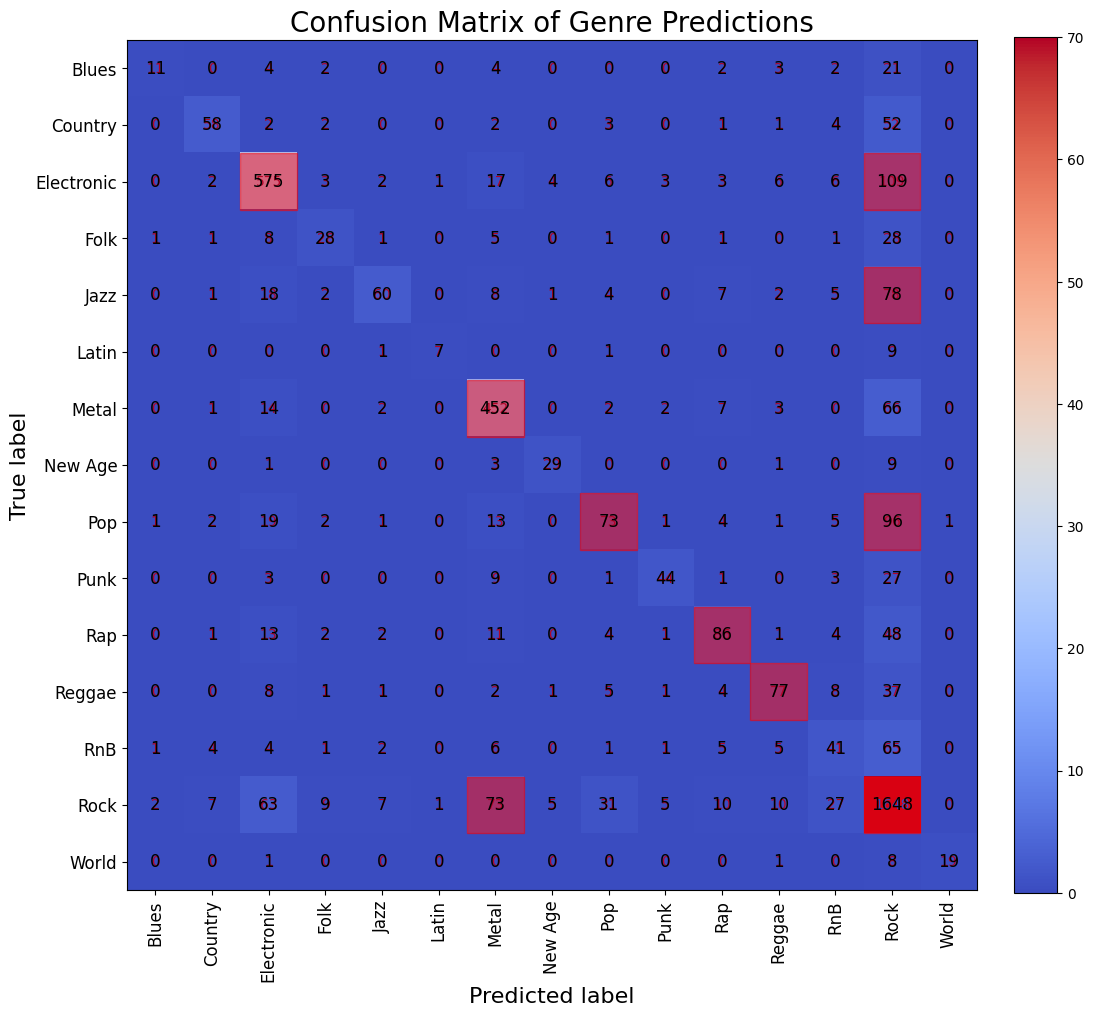

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# Get predictions for all test songs
y_test_pred = []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        y_test_pred.extend(predicted.cpu().numpy())

# Generate confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Custom colormap with fixed range
cmap = plt.cm.coolwarm  # Use the "Coolwarm" colormap
norm = mcolors.Normalize(vmin=0, vmax=70)  # Normalize values to a fixed range (0 to 70)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(12, 12))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
im = disp.plot(xticks_rotation=90, ax=ax, cmap=cmap, colorbar=False)

# Add custom coloring for cells >= 70
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if cm[i, j] >= 70:
            # Highlight the box with a red background
            ax.add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, fill=True, color='red', alpha=0.5))
        # Display all numbers in black for consistency
        ax.text(j, i, f'{cm[i, j]}', ha='center', va='center', color='black', fontsize=12)

# Add a color bar with the adjusted range (0 to 70)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)

plt.title("Confusion Matrix of Genre Predictions", fontsize=20)
plt.xlabel("Predicted label", fontsize=16)
plt.ylabel("True label", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()


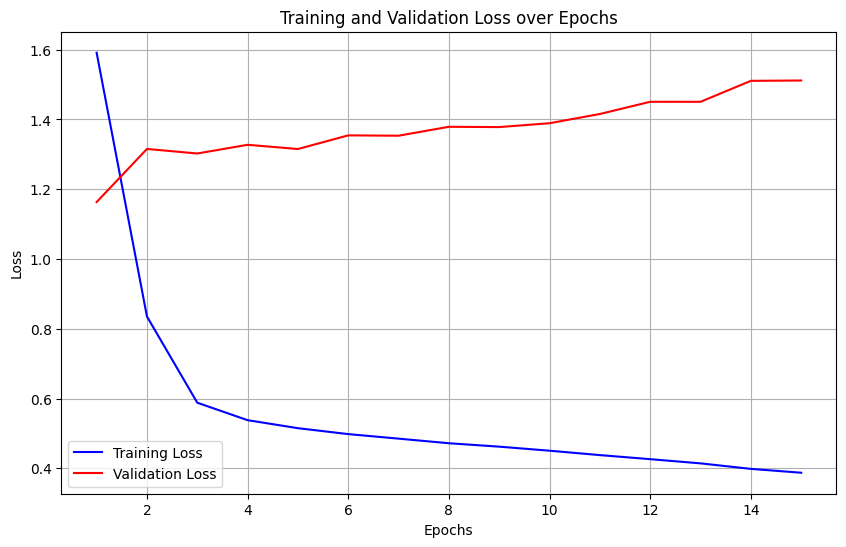

In [14]:
#Visualizing the training and test loss
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, 'b-', label='Training Loss')
plt.plot(epochs, test_losses, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()